<a href="https://colab.research.google.com/github/ricklopez/0201-coolapp/blob/master/CV_Assignment_2_Richard_Lopez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import numpy as np
import cv2

## #a) Load the oxford_iiit_pet dataset

In [2]:
import tensorflow_datasets as tfds


In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [4]:
def read_and_preprocess(data):
  input_image = tf.image.resize(data['image'], (128, 128))
  input_mask = tf.image.resize(data['segmentation_mask'], (128, 128))
  
  input_image = tf.image.convert_image_dtype(input_image, tf.float32) # [0,1]
  input_mask -= 1 # {1,2,3} to {0,1,2}

  return input_image, input_mask

In [5]:
train = dataset['train'].map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(read_and_preprocess)

In [6]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

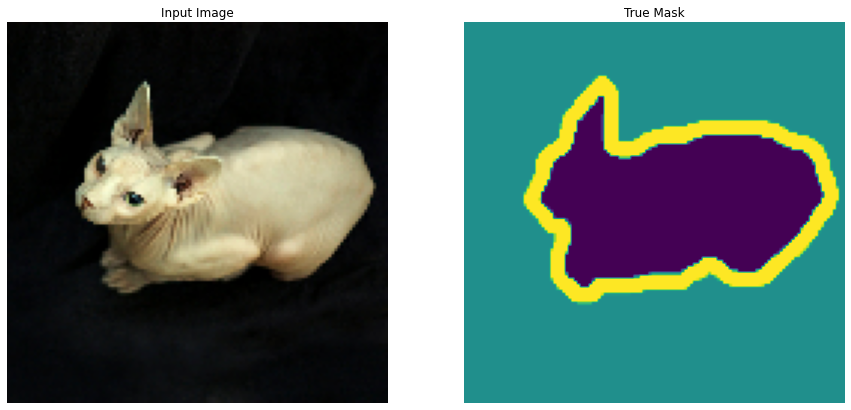

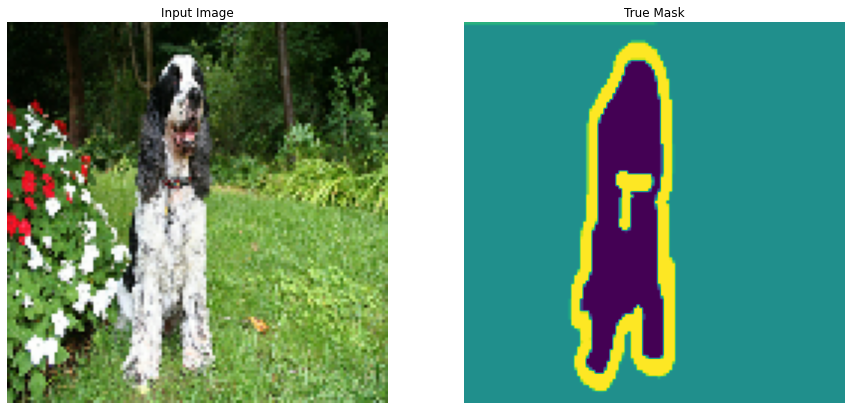

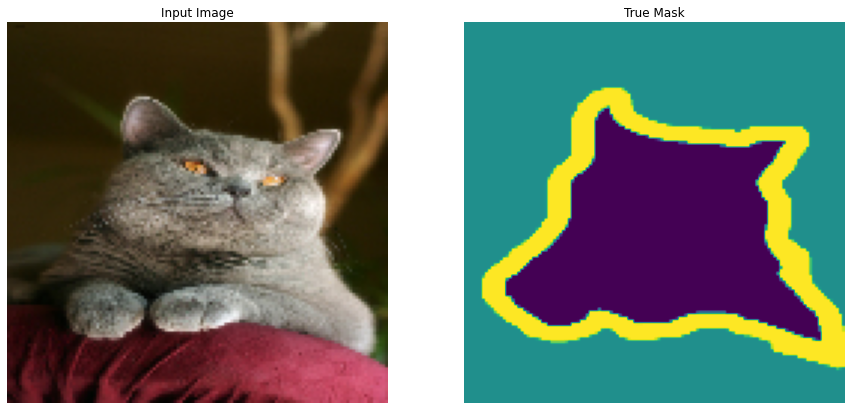

In [7]:
for image, mask in train.take(3):
  sample_image, sample_mask = image, mask
  display([sample_image, sample_mask])

## Summary


# Part 2 - Annotation**
-----

In [17]:
!pip install icevision[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 188 kB 4.3 MB/s 
     |████████████████████████████████| 798 kB 45.9 MB/s 
     |████████████████████████████████| 1.9 MB 39.0 MB/s 
     |████████████████████████████████| 529 kB 42.3 MB/s 
     |████████████████████████████████| 182 kB 41.9 MB/s 
     |████████████████████████████████| 166 kB 34.0 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 166 kB 40.5 MB/s 
     |████████████████████████████████| 162 kB 46.2 MB/s 
     |████████████████████████████████| 162 kB 45.8 MB/s 
     |████████████████████████████████| 158 kB 35.4 MB/s 
     |████████████████████████████████| 157 kB 44.5 MB/s 
     |████████████████████████████████| 157 kB 46.1 MB/s 
     |████████████████████████████████| 157 kB 44.2 MB/s 
     |████████████████████████████████| 157 kB 38.8 MB/s 
     |████████████████████████████

In [12]:
# Install mrcnn
!pip install mrcnn scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
!git clone https://github.com/datitran/raccoon_dataset

Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 652, done.
remote: Total 652 (delta 0), reused 0 (delta 0), pack-reused 652
Receiving objects: 100% (652/652), 48.01 MiB | 20.09 MiB/s, done.
Resolving deltas: 100% (415/415), done.


In [14]:
import os

In [27]:
!git clone https://github.com/ultralytics/yolov5  # clone

Cloning into 'yolov5'...
remote: Enumerating objects: 14919, done.
remote: Counting objects: 100% (250/250), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 14919 (delta 156), reused 194 (delta 111), pack-reused 14669
Receiving objects: 100% (14919/14919), 13.67 MiB | 20.08 MiB/s, done.
Resolving deltas: 100% (10298/10298), done.


In [28]:
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.2-239-gf33718f Python-3.7.15 torch-1.10.2+cu102 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.8/107.7 GB disk)


In [31]:
!pip install icevision[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
from icevision.parsers import VOCBBoxParser

In [40]:
from pathlib import Path

In [51]:
raccoon_data_dir = Path('raccoon_dataset')
raccoon_parser = VOCBBoxParser(annotations_dir=raccoon_data_dir /'annotations', images_dir=raccoon_data_dir /'images')

In [52]:
raccoon_train_records, raccoon_valid_records = raccoon_parser.parse()

  0%|          | 0/200 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/200 [00:00<?, ?it/s]

In [46]:
from icevision.visualize import show_records

In [48]:
import random

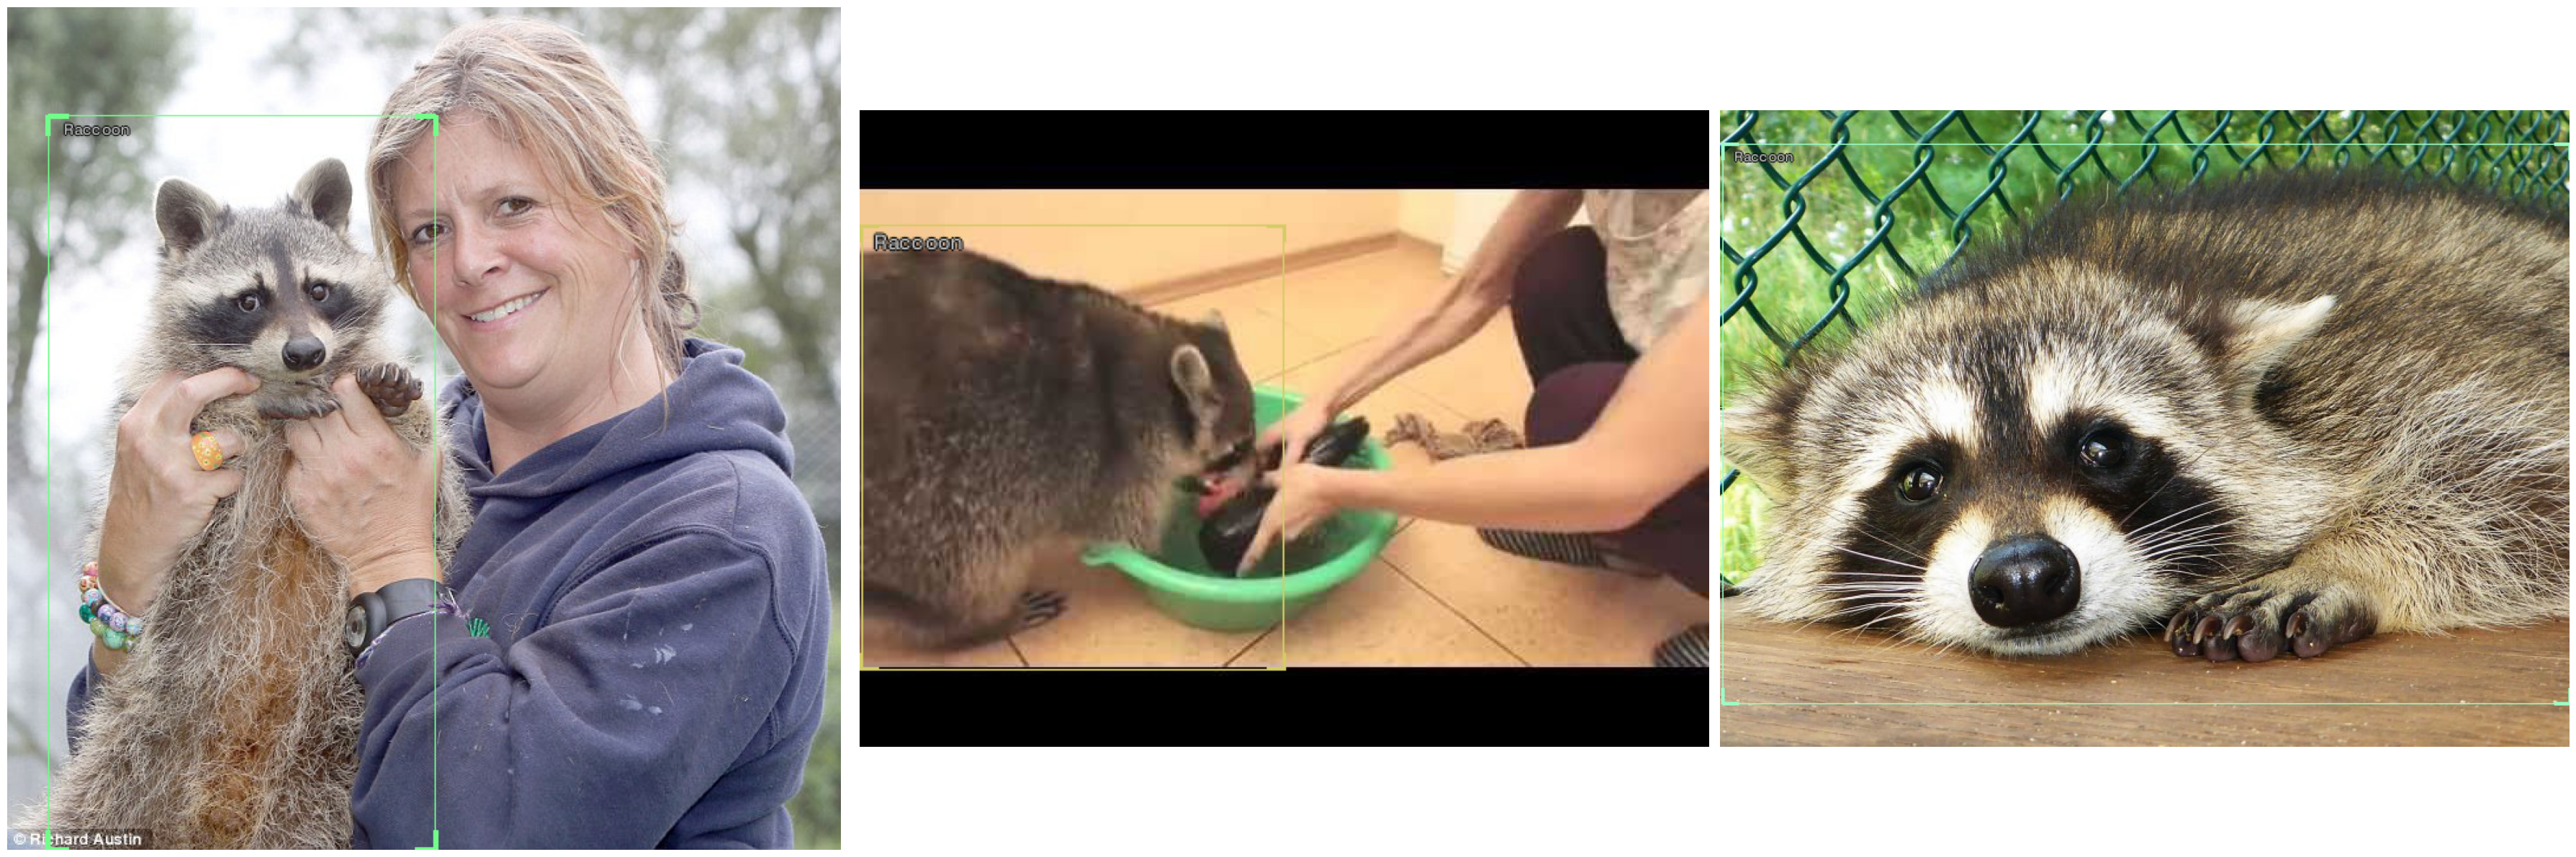

In [57]:
show_records(random.choices(raccoon_train_records, k=3), ncols=3)

In [58]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
 
# class that defines and loads the raccoon dataset
class RaccoonDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("raccoon_dataset", 1, "raccoon")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annotations/raccoon-'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[8:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
 
	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height
 
	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		#path = '/content/raccoon_dataset/annotations/raccoon-'+image_id   #Added by me
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('raccoon'))
		return masks, asarray(class_ids, dtype='int32')
 
	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']
 
# train set
train_set = RaccoonDataset()
train_set.load_dataset('raccoon_dataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
# test/val set
test_set = RaccoonDataset()
test_set.load_dataset('raccoon_dataset', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 149
Test: 51


In [59]:
# load an image
# Use the function above to create the image and 
# load an image
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
# enumerate all images in the dataset
for image_id in train_set.image_ids:
	# load image info
	info = train_set.image_info[image_id]
	# display on the console
	print(info)

(640, 426, 3)
(640, 426, 1)
{'id': '115', 'source': 'dataset', 'path': 'raccoon_dataset/images/raccoon-115.jpg', 'annotation': 'raccoon_dataset/annotations/raccoon-115.xml'}
{'id': '3', 'source': 'dataset', 'path': 'raccoon_dataset/images/raccoon-3.jpg', 'annotation': 'raccoon_dataset/annotations/raccoon-3.xml'}
{'id': '126', 'source': 'dataset', 'path': 'raccoon_dataset/images/raccoon-126.jpg', 'annotation': 'raccoon_dataset/annotations/raccoon-126.xml'}
{'id': '15', 'source': 'dataset', 'path': 'raccoon_dataset/images/raccoon-15.jpg', 'annotation': 'raccoon_dataset/annotations/raccoon-15.xml'}
{'id': '62', 'source': 'dataset', 'path': 'raccoon_dataset/images/raccoon-62.jpg', 'annotation': 'raccoon_dataset/annotations/raccoon-62.xml'}
{'id': '13', 'source': 'dataset', 'path': 'raccoon_dataset/images/raccoon-13.jpg', 'annotation': 'raccoon_dataset/annotations/raccoon-13.xml'}
{'id': '22', 'source': 'dataset', 'path': 'raccoon_dataset/images/raccoon-22.jpg', 'annotation': 'raccoon_datas